In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.vision.models.wrn import wrn_22
from fastai.metrics import accuracy
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
path = untar_data(URLs.CIFAR)
bs=64
ds_tfms = ([*rand_pad(4, 32), flip_lr(p=0.5)], [])
data = ImageDataBunch.from_folder(path, valid='test', ds_tfms=ds_tfms, bs=bs).normalize(cifar_stats)

In [4]:
# Callback for generating FGSM perturbation
class FGSM(LearnerCallback):
    def __init__(self):
        super().__init__(learn)
        self.model = learn.model
        
    def on_batch_begin(self, **kwargs):
        X = kwargs['last_input'].clone()
        y = kwargs['last_target']
        if not kwargs['train']:       
            X = self.fgsm(X, y)
            return {'last_input': X}
    
    def fgsm(self, X, y, epsilon=8/255):
        x = X.clone().detach()
        x = to_device(x, device)
        y = to_device(y, device)
        x = x.requires_grad_(True)
        with torch.enable_grad():
            out = self.model(x)
            losses = nn.CrossEntropyLoss(reduction='none')(out, y)
            loss = torch.mean(losses)
            grad, = torch.autograd.grad(loss, [x])
        x = x + torch.sign(grad) * epsilon
        x = torch.clamp(x, 0, 1)
        return x

In [5]:
# Create a learner
learn = Learner(data, wrn_22(), metrics=accuracy).to_fp16()

In [6]:
# Train model
learn.fit_one_cycle(2, 3e-3, wd=0.4, div_factor=10, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.125276,1.363153,0.524000,00:35
1,0.635978,0.564234,0.801600,00:34


In [7]:
# Generate FGSM perturbation
# learn.to_fp32() # This is a workaround for "RuntimeError: expected scalar type Half but found Float" due to Mixed Precision trainig
# learn.validate(data.valid_dl, callbacks=[FGSM()])

In [25]:
x, y = data.one_batch()

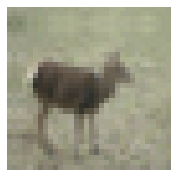

In [26]:
# Original image
img = Image(x[0])
img.show()

In [27]:
learn.predict(img)

(Category deer,
 tensor(4),
 tensor([5.2740e-04, 4.1687e-05, 4.4127e-02, 3.6583e-03, 9.1325e-01, 1.2043e-02,
         4.2262e-03, 2.1994e-02, 9.5307e-05, 3.5030e-05]))

In [28]:
learn.to_fp32() # This is a workaround for "RuntimeError: expected scalar type Half but found Float" due to Mixed Precision trainig
x_adv = FGSM().fgsm(x, y, epsilon=0.03)

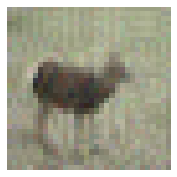

In [29]:
# Adversarial image
adv_img = Image(x_adv[0].detach()) # Detach to wrokaround "RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead."
adv_img.show()

In [30]:
learn.predict(Image(x_adv[0].cpu())) # Moving the data back to cpu gets around "RuntimeError: cannot pin 'torch.cuda.FloatTensor' only dense CPU tensors can be pinned"

(Category bird,
 tensor(2),
 tensor([0.0055, 0.0013, 0.4782, 0.0310, 0.3574, 0.0369, 0.0727, 0.0149, 0.0012,
         0.0009]))